In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import os

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base() # Create a base class for ORM mapping

Base.prepare(autoload_with=engine) # Reflect the tables from the SQLite database



# reflect the tables
print("Tables found in the database:", Base.classes.keys())



Tables found in the database: ['measurement', 'station']


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement # Reference to the 'measurement' table
Station = Base.classes.station # Reference to the 'station' table
#session = Session(engine)



In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date in Dataset: {most_recent_date}")



Most Recent Date in Dataset: 2017-08-23


Most Recent Date in Dataset: 2017-08-23


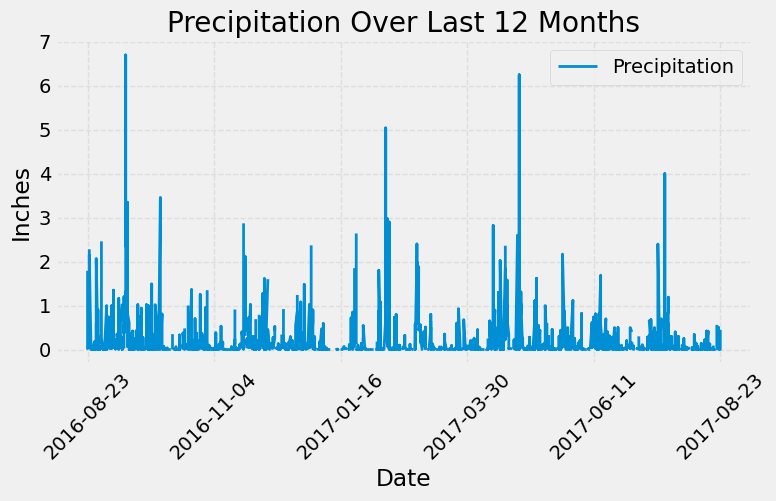

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date in Dataset: {most_recent_date}")

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
#data = session.query(Measurement.date, Measurement.prcp).all()
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()




# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(data, columns=['date', 'prcp'])



# Sort the dataframe by date
df_precipitation = df_precipitation.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 4))
plt.plot(df_precipitation['date'], df_precipitation['prcp'], label="Precipitation", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Over Last 12 Months")
plt.xticks(pd.date_range(start=df_precipitation['date'].min(), end=df_precipitation['date'].max(), periods=6).strftime('%Y-%m-%d'), rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
# Print summary statistics
print(df_precipitation.describe())




In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"Number of Stations: {station_count}")



Number of Stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations: {active_stations}")



Most Active Stations: [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
print(f"Most Active Station: {most_active_station}")
temps = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Print temperature statistics
print(f"Temperature Stats (Min, Max, Avg) for {active_stations}: {temps}")

Most Active Station: USC00519281
Temperature Stats (Min, Max, Avg) for [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]: [(54.0, 85.0, 71.66378066378067)]


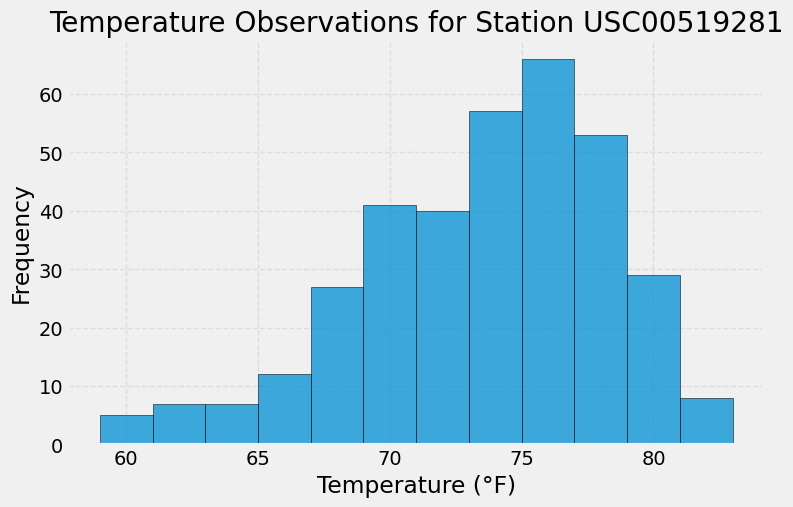

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

df_tobs = pd.DataFrame(tobs_data, columns=['tobs'])
plt.figure(figsize=(8, 5))
plt.hist(df_tobs['tobs'], bins=12, alpha=0.75, edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



# Close Session

In [16]:
# Close Session
session.close()